In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate  = 1e-2
momentum = 0.5
epochs = 100

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([224, 224]),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False
)

In [6]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # input [batch,3,224,224] -> [batch,512,7,7]
        self.features = nn.Sequential(
            # Block1: input [batch,3,224,224] -> [batch,64,112,112]
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            # Block2: input [batch,64,112,112] -> [batch,128,56,56]
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            # Block3: input [batch,128,56,56] -> [batch,256,28,28]
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            # Block4: input [batch,256,28,28] -> [batch,512,14,14]
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            # Block5: input [batch,256,14,14] -> [batch,512,7,7]
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )
        self.classifier=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(7 * 7 * 512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        # [batch,3,224,224]
        batch_size=x.size(0)

        # [batch,512,7,7]
        x=self.features(x)

        # [batch,512*7*7]
        x=x.view(batch_size, -1)

        # [batch,10]
        logits=self.classifier(x)

        return logits

In [7]:
net = VGG16().to(DEVICE)
# net = models.vgg16().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.5, patience=3)

In [8]:
def train(epoch):
    train_loss = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)

    return train_loss

In [9]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [10]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [11]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [12]:
def plot_acc(acc):
    plt.style.use('seaborn')

    acc = np.array(acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(acc, color='blue', label='Validation acc')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='acc')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [13]:
def main():
    train_losses = []
    validate_losses = []
    acc = []
    for epoch in range(epochs):
        train_loss = train(epoch)
        train_losses.append(train_loss)
        validate_loss, validate_acc = validate()
        validate_losses.append(validate_loss)
        acc.append(validate_acc)
        scheduler.step(validate_loss)

    plot_loss(train_losses, validate_losses)
    plot_acc(acc)

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.325477
Train Epoch: 1 [3200/40000 (8%)]	Loss: 1.966299
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.416306
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.317706
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.669855
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.381669
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.677412
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.339880
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.036224
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.401593
Train Epoch: 1 [32000/40000 (80%)]	Loss: 0.941258
Train Epoch: 1 [35200/40000 (88%)]	Loss: 0.887849
Train Epoch: 1 [38400/40000 (96%)]	Loss: 0.732492

VAL set: Average loss: 0.0333, Accuracy: 6310.0/10000 (63.1%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.186237
Train Epoch: 2 [3200/40000 (8%)]	Loss: 0.957478
Train Epoch: 2 [6400/40000 (16%)]	Loss: 0.983061
Train Epoch: 2 [9600/40000 (24%)]	Loss: 0.904909
Train Epoch: 2 [12800/40000 (32%)]	Loss: 0.888398
Train Epoch: 2 [16000/40000 (40%)]	Loss: 0.600547
Trai

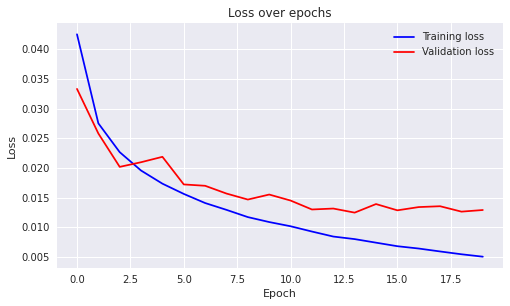

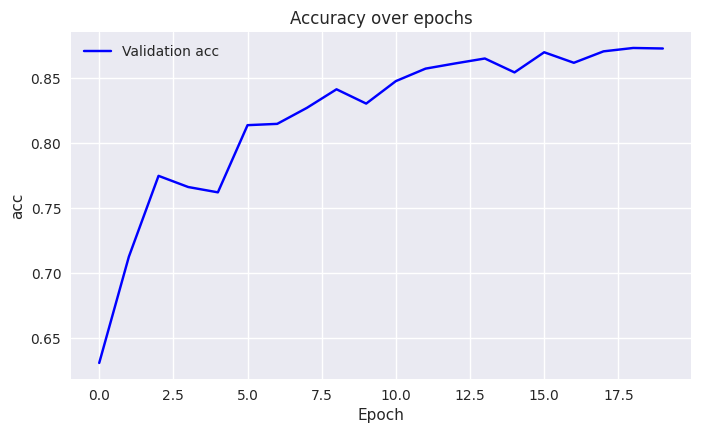

In [14]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'VGG-16 - predictions')

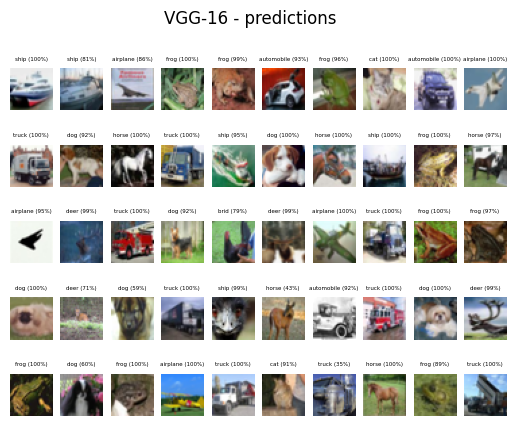

In [15]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('VGG-16 - predictions')


In [ ]:
"""
VGG-16
Mine(batch_size = 32):
After 05 Epoch: 76.2%
After 10 Epoch: 83.1%
After 15 Epoch: 85.5%
After 20 Epoch: 87.3%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─Conv2d: 2-2                       [-1, 64, 224, 224]        36,928
|    └─MaxPool2d: 2-3                    [-1, 64, 112, 112]        --
|    └─BatchNorm2d: 2-4                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-5                         [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─Conv2d: 2-7                       [-1, 128, 112, 112]       147,584
|    └─MaxPool2d: 2-8                    [-1, 128, 56, 56]         --
|    └─BatchNorm2d: 2-9                  [-1, 128, 56, 56]         256
|    └─ReLU: 2-10                        [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─Conv2d: 2-12                      [-1, 256, 56, 56]         590,080
|    └─Conv2d: 2-13                      [-1, 256, 56, 56]         590,080
|    └─MaxPool2d: 2-14                   [-1, 256, 28, 28]         --
|    └─BatchNorm2d: 2-15                 [-1, 256, 28, 28]         512
|    └─ReLU: 2-16                        [-1, 256, 28, 28]         --
|    └─Conv2d: 2-17                      [-1, 512, 28, 28]         1,180,160
|    └─Conv2d: 2-18                      [-1, 512, 28, 28]         2,359,808
|    └─Conv2d: 2-19                      [-1, 512, 28, 28]         2,359,808
|    └─MaxPool2d: 2-20                   [-1, 512, 14, 14]         --
|    └─BatchNorm2d: 2-21                 [-1, 512, 14, 14]         1,024
|    └─ReLU: 2-22                        [-1, 512, 14, 14]         --
|    └─Conv2d: 2-23                      [-1, 512, 14, 14]         2,359,808
|    └─Conv2d: 2-24                      [-1, 512, 14, 14]         2,359,808
|    └─Conv2d: 2-25                      [-1, 512, 14, 14]         2,359,808
|    └─MaxPool2d: 2-26                   [-1, 512, 7, 7]           --
|    └─BatchNorm2d: 2-27                 [-1, 512, 7, 7]           1,024
|    └─ReLU: 2-28                        [-1, 512, 7, 7]           --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Dropout: 2-29                     [-1, 25088]               --
|    └─Linear: 2-30                      [-1, 4096]                102,764,544
|    └─ReLU: 2-31                        [-1, 4096]                --
|    └─Dropout: 2-32                     [-1, 4096]                --
|    └─Linear: 2-33                      [-1, 4096]                16,781,312
|    └─ReLU: 2-34                        [-1, 4096]                --
|    └─Linear: 2-35                      [-1, 10]                  40,970
==========================================================================================
Total params: 134,304,458
Trainable params: 134,304,458
Non-trainable params: 0
Total mult-adds (G): 15.60
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 115.10
Params size (MB): 512.33
Estimated Total Size (MB): 628.00
==========================================================================================
parameters_count: 134304458

Pytorch(batch_size = 64):
After 05 Epoch: 66.4%
After 10 Epoch: 77.3%
After 15 Epoch: 78.9%
After 20 Epoch: 82.3%
structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)
"""